In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

from sigcorr.config import CFG
from sigcorr.tools.utils import get_last_from_iter
from sigcorr.tools.visual import set_plt_reasonable_defaults

from sigcorr.mapreduce.gp import gp_batch_mapreduce
from sigcorr.mapreduce.file import h5_batch_mapreduce

from sigcorr.mapreduce.map_reducers import UpcrossCalc
from sigcorr.mapreduce.map_reducers import SigsCalc
from sigcorr.mapreduce.map_reducers import ChainCalc
from sigcorr.mapreduce.map_reducers import BatchStats1Reduce
from sigcorr.mapreduce.map_reducers import BatchStats2Reduce

from sigcorr.tools.derivative import derivative_along_axes
from sigcorr.tools.stats.gp.upcross import gp_upcross_at_level

from sigcorr.models.gross_vitells import GrossVitells
from sigcorr.models.gross_vitells_asimov import GrossVitellsAsimov
from sigcorr.models.hyy import Hyy
from sigcorr.models.hyy_asimov import HyyAsimov
from sigcorr.models.hyy_2d import Hyy2D
from sigcorr.models.hyy_2d_asimov import Hyy2DAsimov
from sigcorr.models.utils import set_params_from_file


CFG.FITTER.bfit_pool_size = 60  # gp draws use this pool size

set_plt_reasonable_defaults(plt)

In [2]:
input_file = "../../output/hyy-1m.h5"
#input_file = "../../output/gross_vitells-1m.h5"
#input_file = "../../output/hyy2d-2560.h5"
asimov_input_file = input_file.split("-")[0]+"-asimov.h5"

In [3]:
#true_model = GrossVitells(None)
true_model = Hyy(None)
#true_model = Hyy2D(None)
set_params_from_file(true_model, input_file)
true_model.init()

In [4]:
true_res_part = {}
with h5py.File(input_file, "r", swmr=True) as f:
    for field in ["b_loglikes", "sb_loglikes", "sb_params", "sb_params_vars", "bg_samples", "sb_successes", "b_successes", "scan_xs", "sampling_xs"]:
        true_res_part[field] = f[field][:10_000, ...]
    true_res_part["sig_std"] = f.attrs["sig_std"]

In [5]:
#asimov_model = GrossVitellsAsimov(None)
asimov_model = HyyAsimov(true_model.xs)
#asimov_model = Hyy2DAsimov(true_model.xs)
set_params_from_file(asimov_model, asimov_input_file)
asimov_model.init()

In [6]:
asimov_res = {}
with h5py.File(input_file.split("-")[0] + "-asimov.h5", "r") as f:
    for field in ["b_loglikes", "sb_loglikes", "sb_params", "sb_params_vars", "bg_samples", "sb_successes", "b_successes", "scan_xs", "sampling_xs"]:
        asimov_res[field] = f[field][...]

In [7]:
true_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 10_000, SigsCalc(), BatchStats2Reduce()))
true_cov, true_cov_err = true_covcalc.get_cov(), true_covcalc.get_cov_stat_err()
true_corr, true_corr_err = true_covcalc.get_corr(), true_covcalc.get_corr_stat_err()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:04<00:00, 224596.85it/s]


In [8]:
c0 = 0.7

In [9]:
true_euler_number_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 20000, ChainCalc([SigsCalc(), UpcrossCalc(c0)]), BatchStats1Reduce()))
true_euler_number, true_euler_number_err = true_euler_number_covcalc.get_mean(), true_euler_number_covcalc.get_stat_err()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:01<00:00, 517585.27it/s]


In [10]:
asimov_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(asimov_input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 10_000, SigsCalc(), BatchStats2Reduce()))
asimov_cov, asimov_cov_err = asimov_covcalc.get_cov(override_x=np.array(0)), asimov_covcalc.get_cov_stat_err(override_x=np.array(0))
asimov_corr, asimov_corr_err = asimov_covcalc.get_corr(override_x=np.array(0)), asimov_covcalc.get_corr_stat_err(override_x=np.array(0))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 7281777.78it/s]


In [11]:
K = true_corr
xs = true_res_part["sampling_xs"]

In [12]:
K_xdy = derivative_along_axes(K, [xs, xs], [0, 1])

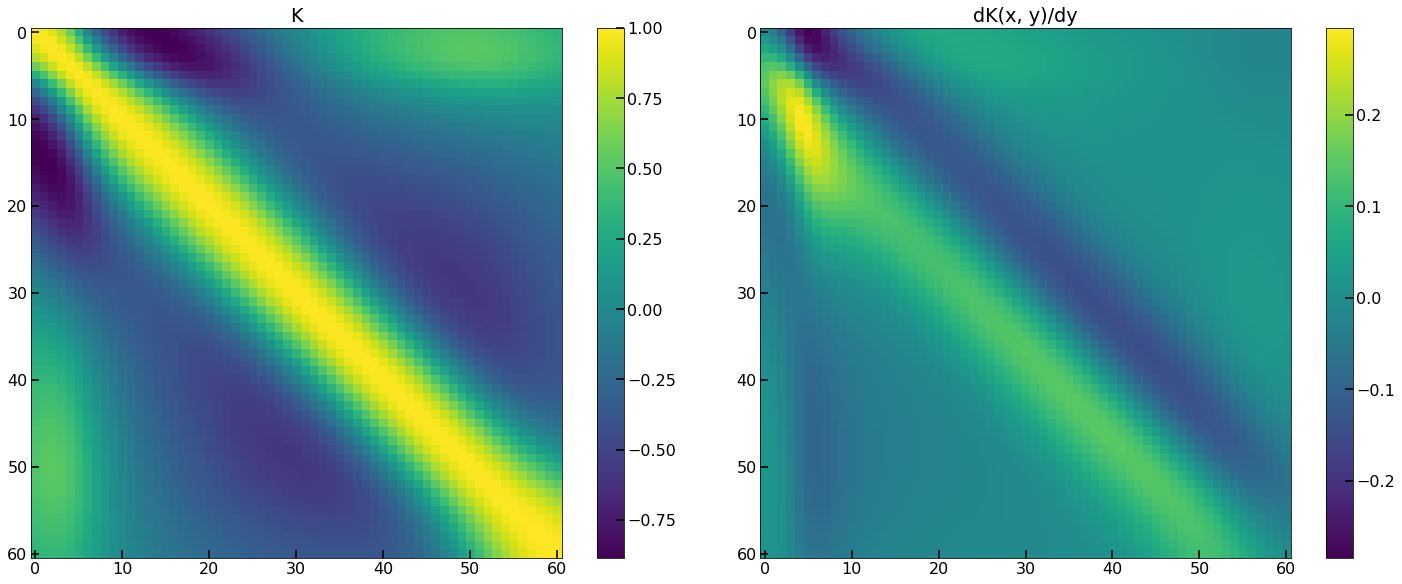

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
m = ax[0].imshow(K, origin="upper")
plt.colorbar(mappable=m, ax=ax[0])
ax[0].set_title("K")
m = ax[1].imshow(K_xdy, origin="upper")
plt.colorbar(mappable=m, ax=ax[1])
ax[1].set_title("dK(x, y)/dy");

In [14]:
K_dxdy = derivative_along_axes(K, [xs, xs], [1, 1])

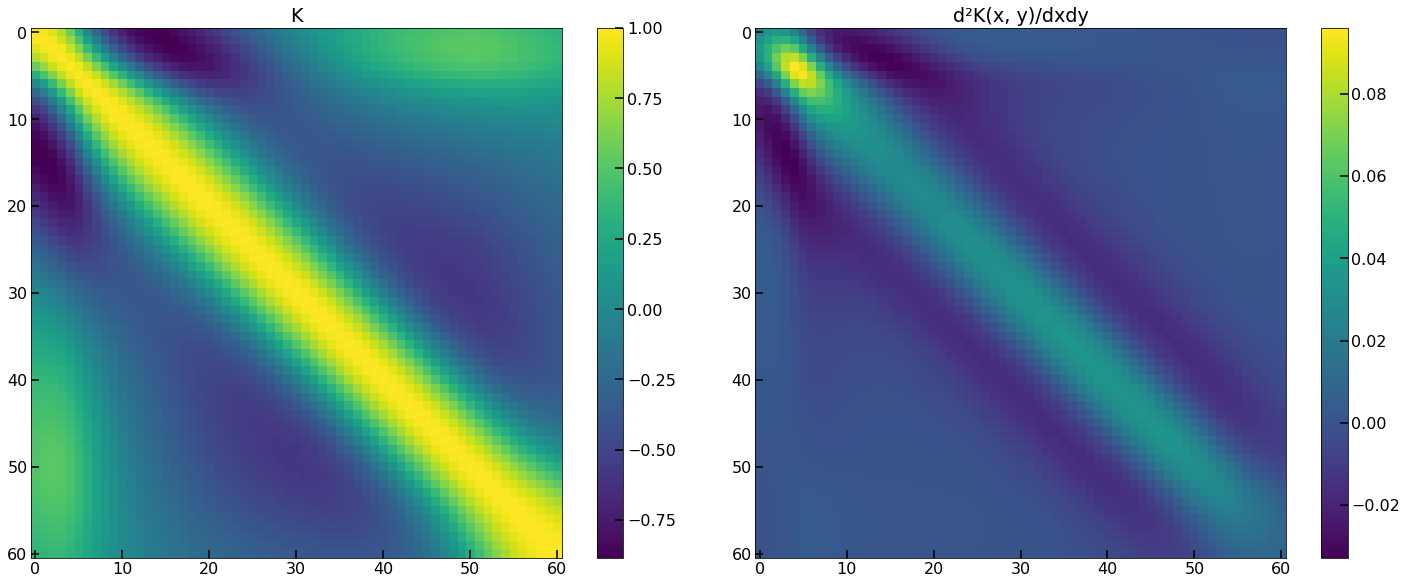

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
m = ax[0].imshow(K, origin="upper")
plt.colorbar(mappable=m, ax=ax[0])
ax[0].set_title("K")
m = ax[1].imshow(K_dxdy, origin="upper")
plt.colorbar(mappable=m, ax=ax[1])
ax[1].set_title("d²K(x, y)/dxdy");

In [16]:
gp_upcross_at_level(true_res_part["scan_xs"][:, 0], true_corr, c0)

1.3933150984906117

In [17]:
gp_upcross_at_level(true_res_part["scan_xs"][:, 0], asimov_corr, c0)

1.3931967176692506

In [18]:
true_euler_number

array([1.390342])

## Stationary kernel test

In [22]:
from sigcorr.tools.euler_number import euler_number_along_zero_ax

from sigcorr.tools.stats.gp.sampling import get_covariance_from_kernel
from sigcorr.tools.stats.gp.sampling import draw_mv_gp
from sigcorr.tools.stats.gp.upcross import _gp_upcross_density
from sigcorr.tools.stats.gp.upcross import integrate_gp_upcross_density

from sigcorr.tools.derivative import finite_diff_der_along_axes
from sigcorr.tools.derivative import spline3_der_along_axes

In [23]:
def stationary_kernel(x, y):
    return np.exp(-(x-y)**2/10)

In [24]:
xs = np.arange(100, 160, 0.5)
stationary_cov = get_covariance_from_kernel(stationary_kernel, xs)

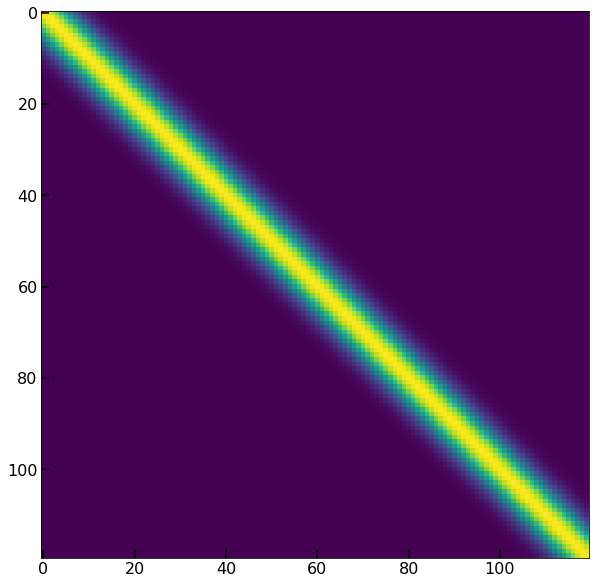

In [25]:
plt.imshow(stationary_cov, origin="upper")

In [26]:
stationary_gp_samples = draw_mv_gp(stationary_cov, 10000)

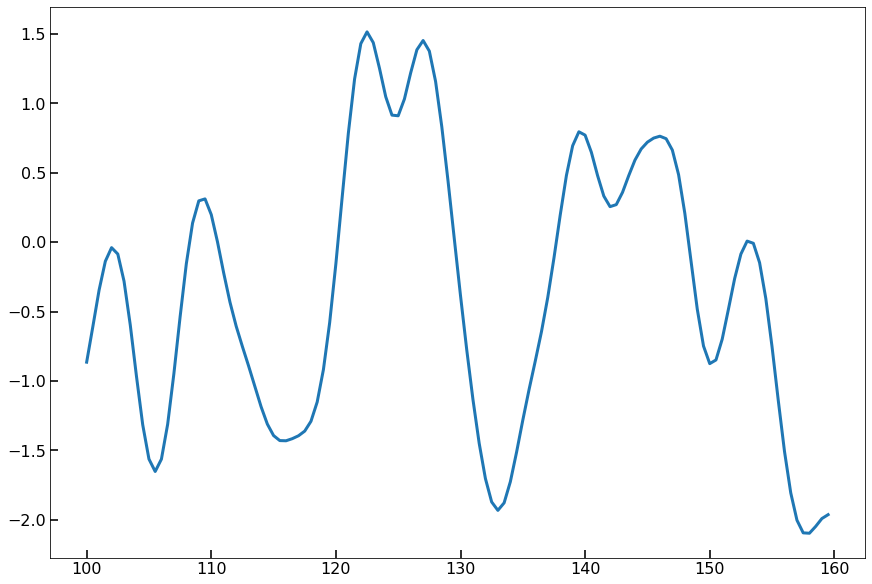

In [27]:
plt.plot(xs, stationary_gp_samples[0])

In [28]:
stationary_gp_euler_num = np.mean(euler_number_along_zero_ax(stationary_gp_samples - c0))
stationary_gp_euler_num_err = np.std(euler_number_along_zero_ax(stationary_gp_samples - c0))/np.sqrt(1000000)
print(stationary_gp_euler_num, " +- ", stationary_gp_euler_num_err)

3.5337  +-  0.0012860265588237282


In [29]:
gp_upcross_at_level(xs, stationary_cov, c0)

3.3141595287536236

In [30]:
integrate_gp_upcross_density(_gp_upcross_density(xs, stationary_cov, c0, finite_diff_der_along_axes), xs)

3.2440572527475635

In [31]:
integrate_gp_upcross_density(_gp_upcross_density(xs, stationary_cov, c0, spline3_der_along_axes), xs)

3.3141595287536236

In [32]:
def gp_euler_num_density_stationary_analyt(xs, K, u):
    sigma_x = np.ones_like(xs)
    sigma_dx = np.sqrt(2/10)
    return 1/2/np.pi*sigma_dx/sigma_x*np.exp(-u**2/2/sigma_x**2)
integrate_gp_upcross_density(gp_euler_num_density_stationary_analyt(xs, stationary_cov, c0), xs)

3.3147436486550355